In [1]:
import numpy as np
import matplotlib.pyplot as plt
import GPy
import dynesty

%matplotlib inline

Covariance matrix

[[1.00000000e+00 9.94911470e-01 9.79800714e-01 ... 1.42487329e-21
  5.26916305e-22 1.92874985e-22]
 [9.94911470e-01 1.00000000e+00 9.94911470e-01 ... 3.81399159e-21
  1.42487329e-21 5.26916305e-22]
 [9.79800714e-01 9.94911470e-01 1.00000000e+00 ... 1.01053670e-20
  3.81399159e-21 1.42487329e-21]
 ...
 [1.42487329e-21 3.81399159e-21 1.01053670e-20 ... 1.00000000e+00
  9.94911470e-01 9.79800714e-01]
 [5.26916305e-22 1.42487329e-21 3.81399159e-21 ... 9.94911470e-01
  1.00000000e+00 9.94911470e-01]
 [1.92874985e-22 5.26916305e-22 1.42487329e-21 ... 9.79800714e-01
  9.94911470e-01 1.00000000e+00]]


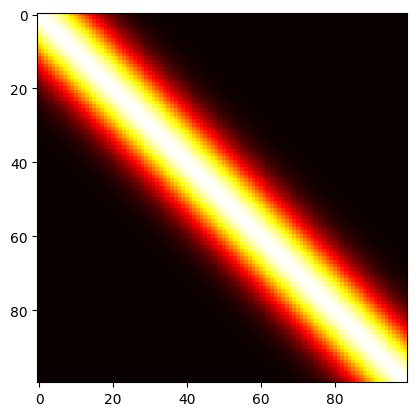

In [2]:
# Assume you have some time points t and observations y
t = np.linspace(0, 10, 100).reshape(-1, 1)  # Example time points
y = np.random.normal(size=(100, 1))  # Example observations

# Define a kernel 
kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)
 
# Create a GP model
model = GPy.models.GPRegression(t,y, kernel)
# Access the covariance matrix from the model
 
covariance_matrix = model.kern.K(t) 
print(covariance_matrix)
plt.imshow(covariance_matrix, cmap='hot')

Generate a tiktok signal

Tick-tock signal:

$$ y(t) = A(t) \sin (2\pi ~f(t) ~t) $$

where $ A(t) = \exp(-gt) $, $g$ is the amplitude damping factor, and $f(t) = \frac{1}{T_{init} \exp(-ht)}$, $h$ being the frequency damping factor and $T_{init}$ the initial period.

Gradients:

$$ dy/dT_{init} = A(t) \cos(2\pi ~f(t) ~t) (-2\pi t/T_{init}^2 \exp(-ht)) $$
$$ dy/dg = -t A(t) \sin (2\pi ~f(t)~t) $$
$$ dy/dh = A(t) \cos(2\pi ~f(t) ~t) (2\pi t^2/T_{init}) $$

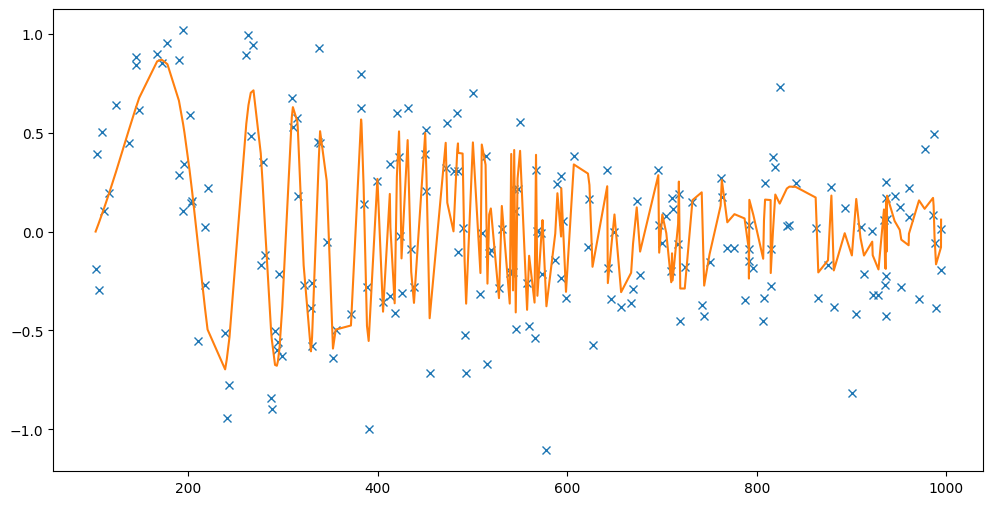

In [3]:
# seed the random number generator
rstate = np.random.default_rng(916301)

def try_generate_tiktok_signal(time_instances, params):
    T_init, g, h = params
    frequency = 1 / (T_init * np.exp(-h * time_instances))
    amplitude = np.exp(-g * time_instances)
    tiktok_signal = amplitude * np.sin(2 * np.pi * frequency * time_instances)
    return tiktok_signal

real_times = np.sort(np.random.uniform(100,1000,200))
trial = try_generate_tiktok_signal(real_times - real_times.min(), (500, 0.002, 0.008))
y = rstate.normal(trial, 0.25) # sigma is the second argument
plt.figure(figsize=(12,6))
plt.plot(real_times, y, 'x')
plt.plot(real_times, trial)

Create the specific mean class for a tick-tock signal

In [4]:
class TicktockMean(GPy.core.Mapping):
    def __init__(self, input_dim, T_init, g, h):
        super(TicktockMean, self).__init__(input_dim=input_dim, output_dim=1, name="Ticktock_mean")
        self.T_init = GPy.Param("T_init",T_init)
        self.g = GPy.Param("g",g)
        self.h = GPy.Param("h",h)
        self.link_parameters(self.T_init, self.g, self.h)
    
    def f(self, X):
        frequency = 1 / (self.T_init * np.exp(-self.h * X))
        amplitude = np.exp(-self.g * X)
        tiktok_signal = amplitude * np.sin(2 * np.pi * frequency * X)
        return tiktok_signal
    
    def update_gradients(self, dL_dF, X):
        frequency = 1 / (self.T_init * np.exp(-self.h * X))
        amplitude = np.exp(-self.g * X)
        self.T_init.gradient = np.sum(dL_dF*amplitude*np.cos(2*np.pi*frequency*X)*(-2*np.pi*X/(self.T_init**2*np.exp(-self.h*X))))
        self.h.gradient = np.sum(dL_dF*amplitude*np.cos(2*np.pi*frequency*X)*(-2*np.pi*X**2/(self.T_init)))
        self.g.gradient = np.sum(dL_dF*(-X)*amplitude*np.sin(2*np.pi*frequency*X))

Apply it to a GP

 /tmp/ipykernel_28042/1511602392.py:10: RuntimeWarning:overflow encountered in divide
 /tmp/ipykernel_28042/1511602392.py:12: RuntimeWarning:overflow encountered in multiply
 /tmp/ipykernel_28042/1511602392.py:12: RuntimeWarning:invalid value encountered in sin
 /tmp/ipykernel_28042/1511602392.py:16: RuntimeWarning:overflow encountered in divide
 /tmp/ipykernel_28042/1511602392.py:18: RuntimeWarning:overflow encountered in multiply
 /tmp/ipykernel_28042/1511602392.py:18: RuntimeWarning:invalid value encountered in cos
 /tmp/ipykernel_28042/1511602392.py:18: RuntimeWarning:overflow encountered in divide
 /tmp/ipykernel_28042/1511602392.py:19: RuntimeWarning:overflow encountered in multiply
 /tmp/ipykernel_28042/1511602392.py:19: RuntimeWarning:invalid value encountered in cos
 /tmp/ipykernel_28042/1511602392.py:20: RuntimeWarning:overflow encountered in multiply
 /tmp/ipykernel_28042/1511602392.py:20: RuntimeWarning:invalid value encountered in sin
 /tmp/ipykernel_28042/1511602392.py:10


Name : GP regression
Objective : 252.93116832592153
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  GP_regression.           |  value  |  constraints  |  priors
  Ticktock_mean.T_init     |  500.0  |               |        
  Ticktock_mean.g          |  0.002  |               |        
  Ticktock_mean.h          |  0.008  |               |        
  Mat32.variance           |    1.0  |      +ve      |        
  Mat32.lengthscale        |    1.0  |      +ve      |        
  Gaussian_noise.variance  |    1.0  |      +ve      |        


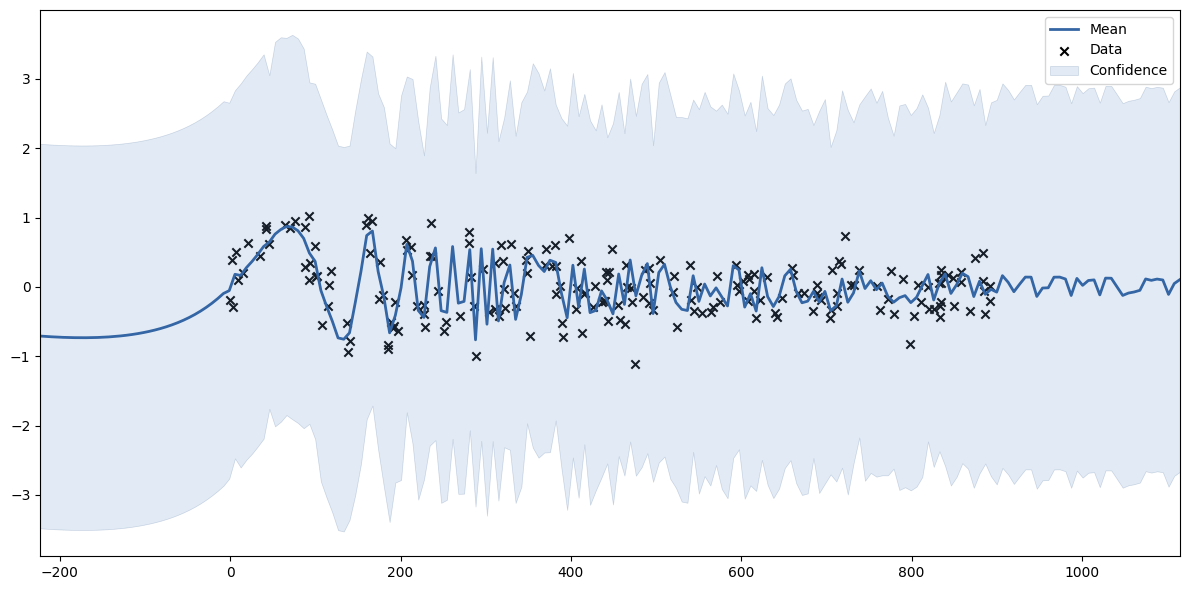

In [11]:
meanfxn = TicktockMean(input_dim=1,T_init=500,g=0.002,h=0.008)

ker = GPy.kern.Matern32(1)

m_real = GPy.models.GPRegression(np.reshape(real_times - real_times.min(), (len(real_times), 1)), np.reshape(y, (len(y),1)), kernel=ker, mean_function=meanfxn)
# m_real.optimize()
print(m_real)
_ = m_real.plot(figsize=(12,6))
# plt.xlim(200,400)

I'm having the same problems when using the MLE optimizer inside `GPy` or the nested sampler inside `dynesty`! It boils down to the frequency term

$$ f(t) = \dfrac{1}{T_{init} \exp(-ht)} = \dfrac{\exp(ht)}{T_{init}} $$

where, even if $T_{init} \neq 0$, it will still encounter overflows.